# Process Mining for Email Workflow

Use the 'pm4py' library to create a process mining model of a demo log.
The goal is to be able to identify issues in the SOC Toolkit logs with process mining.

## Features
  * case id   --> 'case:concept:name'
  * timestamp --> 'time:timestamp'
  * activity  --> 'concept:name'
  * resource  --> 'org:resource'

## Process Mining Tools:
   - Alpha Miner
   - Petri Nets
   - Directly Follows Graph (time factor)
   - Replay
   - Diagnostics 

In [216]:
import os
import pm4py

import pandas as pd
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
from pm4py.objects.log.importer.xes import importer as xes_importer

from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.conformance.tokenreplay import algorithm as token_based_replay
from pm4py.algo.discovery.correlation_mining import algorithm as correlation_miner
from pm4py.algo.conformance.tokenreplay.diagnostics import duration_diagnostics

from pm4py.visualization.petrinet import visualizer as pn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization

from pm4py.algo.conformance.tokenreplay.diagnostics import root_cause_analysis
from pm4py.visualization.decisiontree import visualizer as dt_vis
from pm4py.algo.conformance.alignments import algorithm as alignments

In [217]:
class ProcessMining:
    def __init__(self):
        self._event_log = list()

    def print(self, show_slice_list = True) -> None:
        if(show_slice_list):
            print(self._event_log[0:5])
        else:
            print(self._event_log)

    def convert_to_xes(self, _csv_file_name: str, _xes_file_name: str) -> None:
        # parse csv to xes log file
        log_csv = pd.read_csv(_csv_file_name, sep=',')
        log_csv = dataframe_utils.convert_timestamp_columns_in_df(log_csv)
        log_csv = log_csv.sort_values('time:timestamp')
        self._event_log = log_converter.apply(log_csv, variant=log_converter.Variants.TO_EVENT_LOG)
        xes_exporter.apply(self._event_log, _xes_file_name)
        
    def alpha_miner(self) -> None:
        net, initial_marking, final_marking = alpha_miner.apply(self._event_log)
        print("Alpha Miner succeeded!")
        
    def alignments(self) -> None:
        net, initial_marking, final_marking = inductive_miner.apply(self._event_log)
        aligned_traces = alignments.apply_log(self._event_log, net, initial_marking, final_marking)
        print(aligned_traces)
        
    def generate_petri_net_alpha_plus(self) -> None:
        petri_net, initial_marking, final_marking = pm4py.discover_petri_net_alpha_plus(self._event_log)
        pm4py.view_petri_net(petri_net, initial_marking, final_marking, format='png')
        pm4py.save_vis_petri_net(petri_net, initial_marking, final_marking, "petri_net.png")
    
    def directly_follows_graph(self) -> None:
        dfg, start_activities, end_activities = pm4py.discover_dfg(self._event_log)
        pm4py.view_dfg(dfg, start_activities, end_activities, format='png', log=self._event_log)
        pm4py.save_vis_dfg(dfg, start_activities, end_activities, "directly_follows_graph.png", 
                           log=self._event_log)
    
    def frequency_performance_graph(self) -> None:
        df = pd.read_csv('./out/long_correlator_case.csv')
        df = dataframe_utils.convert_timestamp_columns_in_df(df)
        df = df[["concept:name", "time:timestamp"]]
        
        frequency_dfg, performance_dfg = correlation_miner.apply(df, 
            parameters={correlation_miner.Variants.CLASSIC.value.Parameters.ACTIVITY_KEY: "concept:name",
            correlation_miner.Variants.CLASSIC.value.Parameters.TIMESTAMP_KEY: "time:timestamp"})
        activities_freq = dict(df["concept:name"].value_counts())
        gviz_freq = dfg_visualizer.apply(frequency_dfg, variant=dfg_visualizer.Variants.FREQUENCY, 
                                         activities_count=activities_freq, parameters={"format": "png"})
        gviz_perf = dfg_visualizer.apply(performance_dfg, variant=dfg_visualizer.Variants.PERFORMANCE, 
                                         activities_count=activities_freq, parameters={"format": "png"})
        print("Frequency: ")
        dfg_visualizer.view(gviz_freq)
        dfg_visualization.save(gviz_freq, "frequency_dfg.png")
        print("Performance: ")
        dfg_visualizer.view(gviz_perf)
        dfg_visualization.save(gviz_perf, "performance_dfg.png")
        
    
    def process_replay(self) -> None:
        # conformance alignments
        # petri_net, initial_marking, final_marking = pm4py.discover_petri_net_alpha_plus(self._event_log)
        # aligned_traces = pm4py.conformance_alignments(self._event_log, petri_net, initial_marking, final_marking)
        #print(aligned_traces)
        
         # token based replay
        parameters_tbr = {token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.DISABLE_VARIANTS: True, 
                          token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.ENABLE_PLTR_FITNESS: True}
        replayed_traces, place_fitness, trans_fitness, unwanted_activities = token_based_replay.apply(self._event_log,
                                                                                    net, initial_marking,
                                                                                    final_marking,
                                                                                    parameters=parameters_tbr)
        print(place_fitness)
        
    
    def print_diagnostics(self) -> None:
        parameters_tbr = {token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.DISABLE_VARIANTS: True, 
                          token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.ENABLE_PLTR_FITNESS: True}
        replayed_traces, place_fitness, trans_fitness, unwanted_activities = token_based_replay.apply(
                                                                            self._event_log, net,
                                                                            initial_marking,
                                                                            final_marking,
                                                                            parameters=parameters_tbr)
        # throughput analysis
        print(" Throughput Analysis: ")
        trans_diagnostics = duration_diagnostics.diagnose_from_trans_fitness(self._event_log, trans_fitness)
        for trans in trans_diagnostics:
            print(trans, trans_diagnostics[trans])
            
    def root_cause_analysis(self) -> None:
        parameters_tbr = {token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.DISABLE_VARIANTS: False, 
                          token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.ENABLE_PLTR_FITNESS: True}
        replayed_traces, place_fitness, trans_fitness, unwanted_activities = token_based_replay.apply(
                                                                            self._event_log, net,
                                                                            initial_marking,
                                                                            final_marking,
                                                                            parameters=parameters_tbr)
        trans_root_cause = root_cause_analysis.diagnose_from_trans_fitness(self._event_log, trans_fitness)
        for trans in trans_root_cause:
            clf = trans_root_cause[trans]["clf"]
            feature_names = trans_root_cause[trans]["feature_names"]
            classes = trans_root_cause[trans]["classes"]
            # visualization could be called
            gviz = dt_vis.apply(clf, feature_names, classes)
            dt_vis.view(gviz)


## 1. Long Correlator Case

In [218]:
mine = ProcessMining()

In [219]:
# Scenario 1
mine.convert_to_xes(_csv_file_name='./out/long_correlator_case.csv',
                     _xes_file_name='./out/long_correlator_case.xes')
mine.print(show_slice_list=True)

exporting log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

[{'attributes': {'concept:name': 54}, 'events': [{'time:timestamp': Timestamp('2021-01-12 17:18:00.431256+0000', tz='UTC'), 'concept:name': 'executed pre function of component auth_proxy', 'org:resource': 'auth_proxy'}, '..', {'time:timestamp': Timestamp('2021-01-12 17:18:05.031256+0000', tz='UTC'), 'concept:name': 'executed post function of component guardia_api', 'org:resource': 'guardia_api'}]}, {'attributes': {'concept:name': 76}, 'events': [{'time:timestamp': Timestamp('2021-01-12 17:18:00.626463+0000', tz='UTC'), 'concept:name': 'executed pre function of component auth_proxy', 'org:resource': 'auth_proxy'}, '..', {'time:timestamp': Timestamp('2021-01-12 17:18:10.126463+0000', tz='UTC'), 'concept:name': 'executed post function of component guardia_api', 'org:resource': 'guardia_api'}]}, {'attributes': {'concept:name': 106}, 'events': [{'time:timestamp': Timestamp('2021-01-12 17:18:00.692066+0000', tz='UTC'), 'concept:name': 'executed pre function of component auth_proxy', 'org:res

In [220]:
# Alpha Miner
mine.alpha_miner()

Alpha Miner succeeded!


In [221]:
# Alignments
mine.alignments()

[{'alignment': [('>>', None), ('>>', None), ('executed pre function of component auth_proxy', 'executed pre function of component auth_proxy'), ('executed pre function of component guardia_api', 'executed pre function of component guardia_api'), ('executed pre function of component email_service', 'executed pre function of component email_service'), ('executed pre function of component indicator_parser', 'executed pre function of component indicator_parser'), ('executed pre function of component worker', 'executed pre function of component worker'), ('executed pre function of component workflow_engine', 'executed pre function of component workflow_engine'), ('executed pre function of component analytics', 'executed pre function of component analytics'), ('executed pre function of component correlator', 'executed pre function of component correlator'), ('executed pre function of component notification_service', 'executed pre function of component notification_service'), ('executed post 

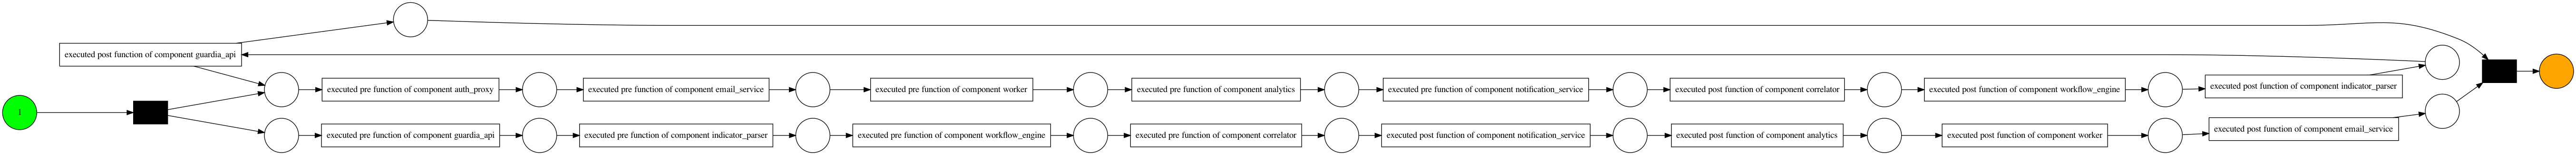

In [222]:
# Discovers a Petri net using the Alpha+ algorithm
mine.generate_petri_net_alpha_plus()

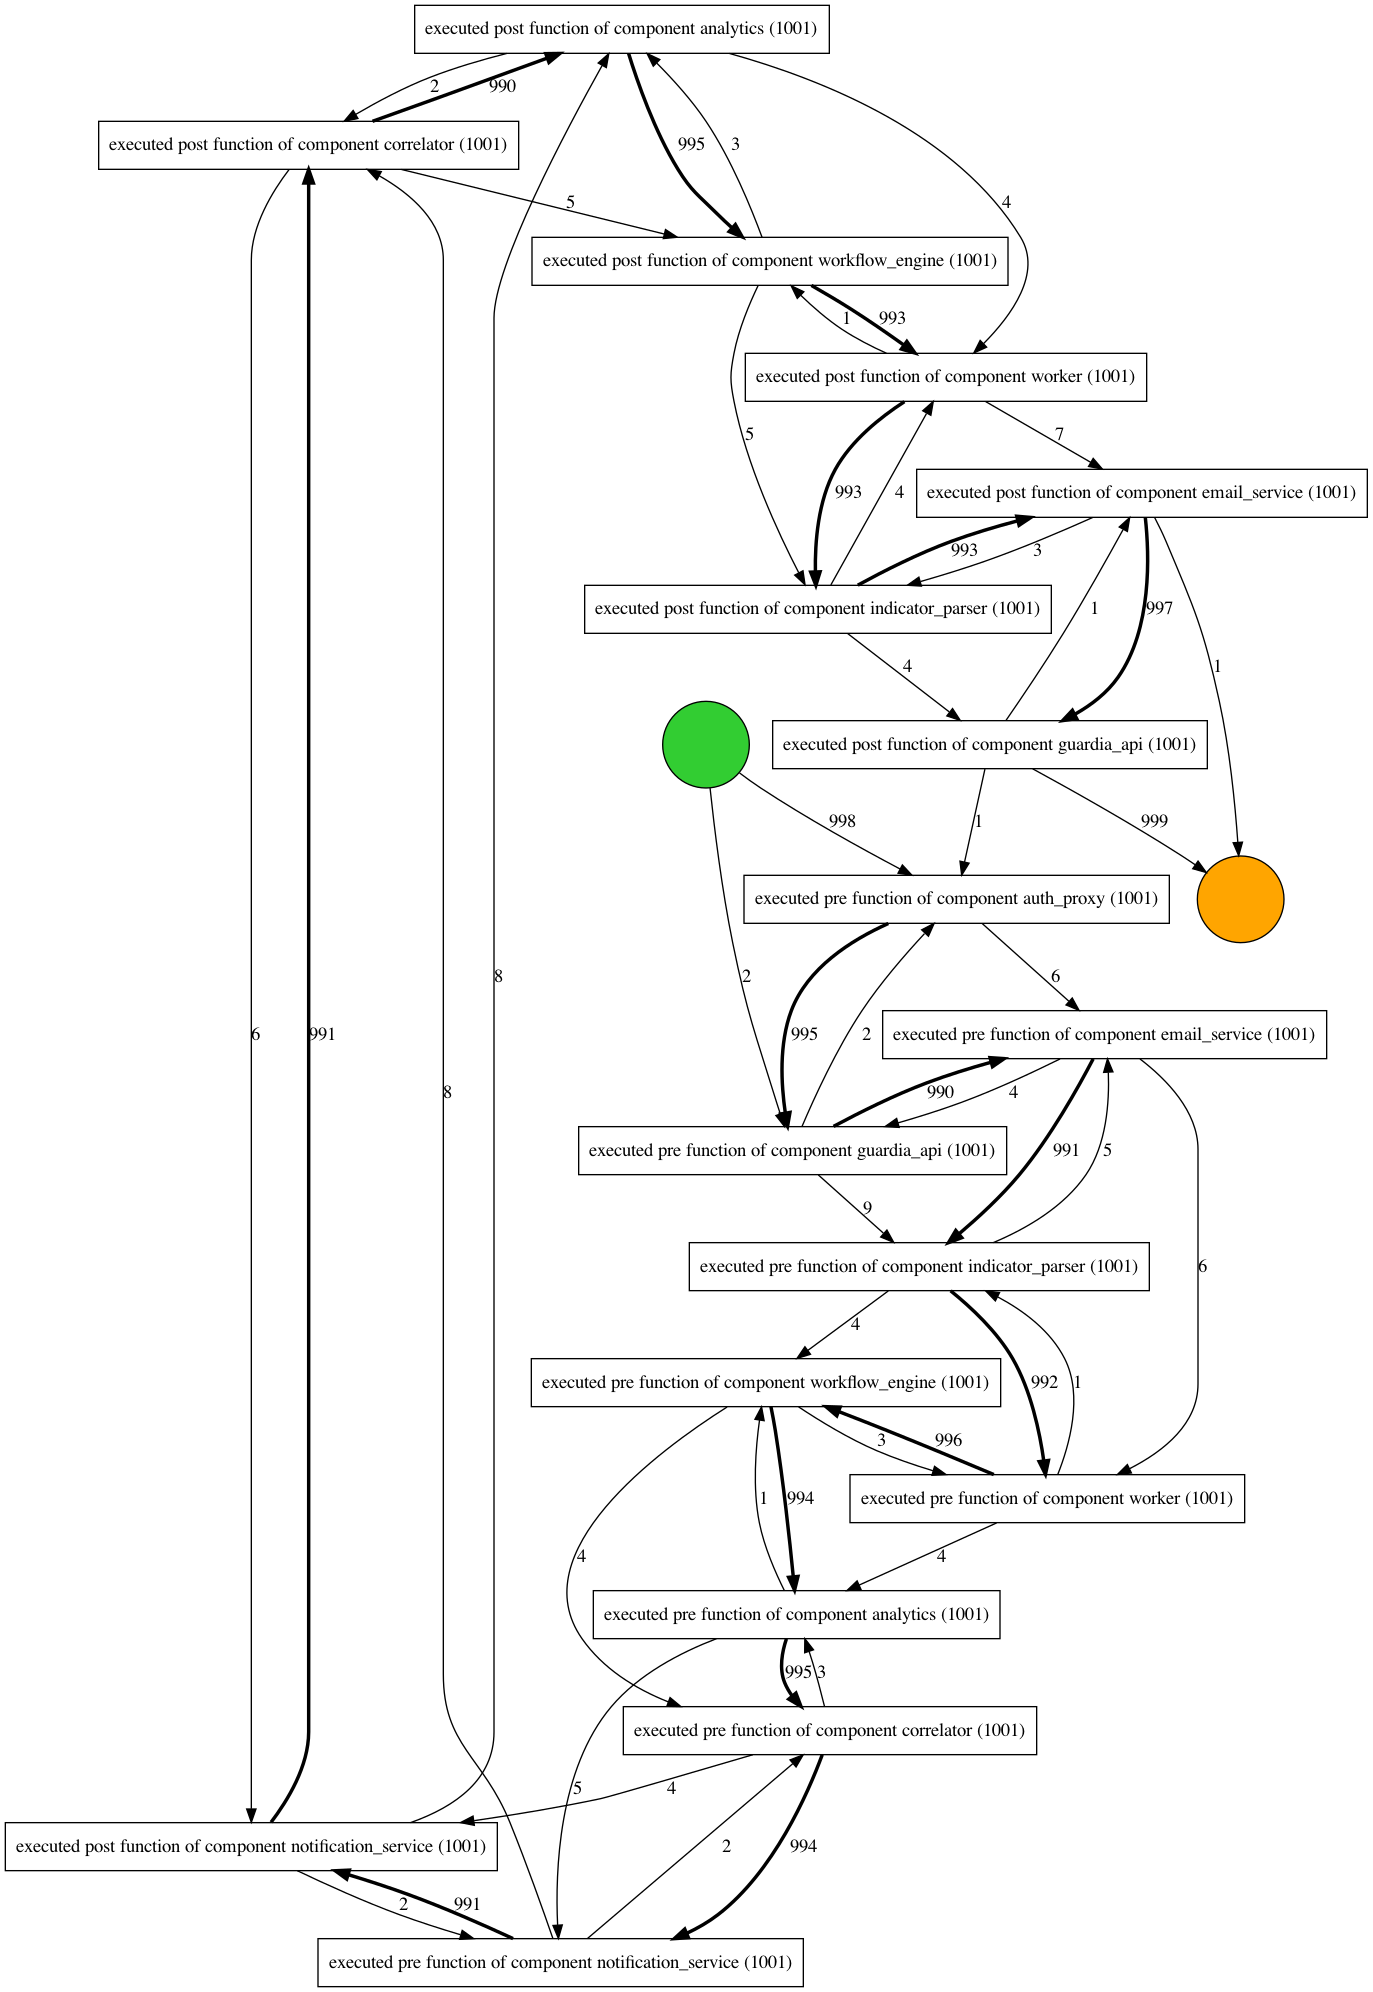

In [223]:
# Discovers a DFG from a log
mine.directly_follows_graph()

Frequency: 


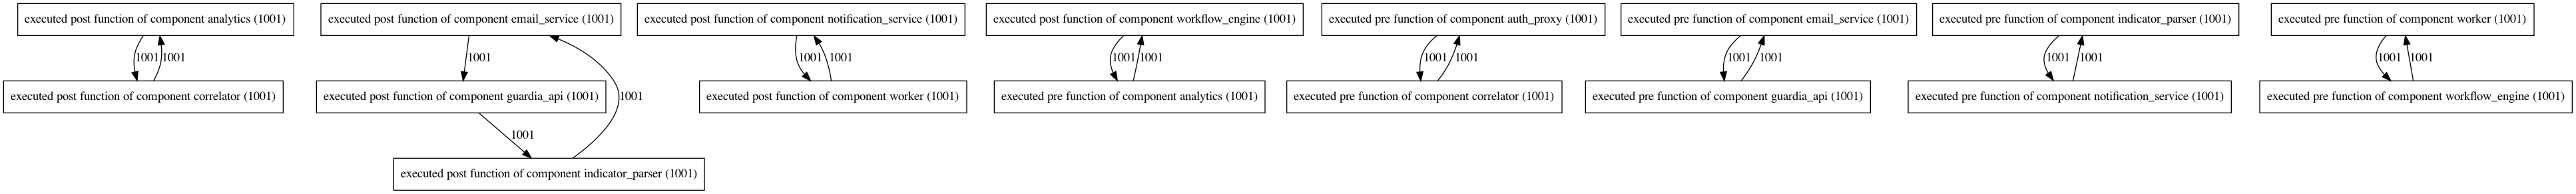

Performance: 


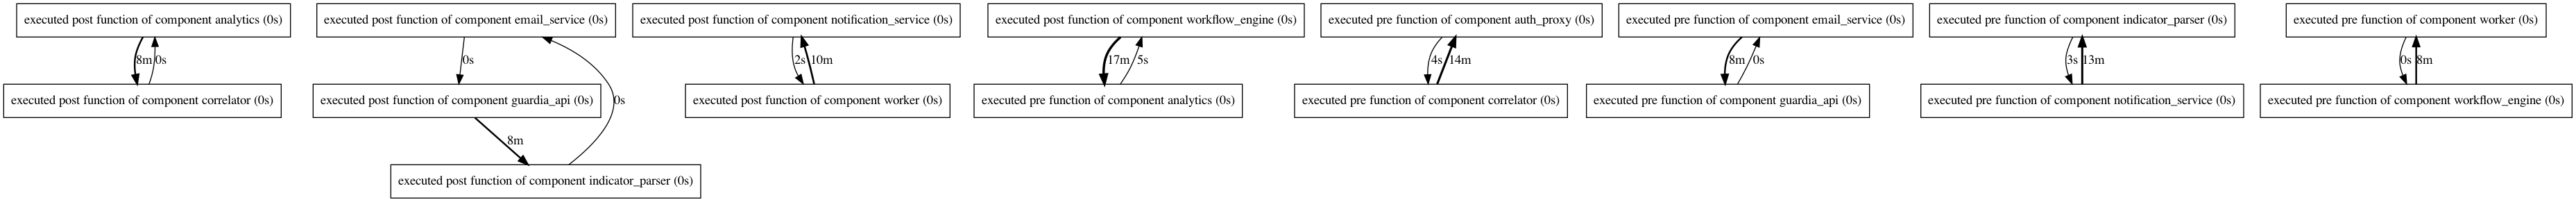

In [224]:
# Performance Graph
mine.frequency_performance_graph()

In [225]:
# Process Replay
mine.process_replay()

{({'executed post function of component indicator_parser'}, {'executed post function of component guardia_api'}): {'underfed_traces': set(), 'overfed_traces': set(), 'm': 0, 'r': 0, 'c': 1001, 'p': 1001}, ({'executed pre function of component workflow_engine'}, {'executed pre function of component correlator'}): {'underfed_traces': set(), 'overfed_traces': set(), 'm': 0, 'r': 0, 'c': 1001, 'p': 1001}, ({'executed pre function of component correlator'}, {'executed post function of component notification_service'}): {'underfed_traces': set(), 'overfed_traces': set(), 'm': 0, 'r': 0, 'c': 1001, 'p': 1001}, ({'executed post function of component correlator'}, {'executed post function of component workflow_engine'}): {'underfed_traces': set(), 'overfed_traces': set(), 'm': 0, 'r': 0, 'c': 1001, 'p': 1001}, start: {'underfed_traces': {{'attributes': {'concept:name': 104}, 'events': [{'time:timestamp': Timestamp('2021-01-12 17:18:06.525546+0000', tz='UTC'), 'concept:name': 'executed pre funct

In [226]:
# Diagnostics
mine.print_diagnostics()

 Throughput Analysis: 
executed pre function of component guardia_api {'n_fit': 2, 'n_underfed': 998, 'fit_median_time': 4.85, 'underfed_median_time': 6.8, 'relative_throughput': 1.4020618556701032}


In [228]:
# Root Cause Analysis
# mine.root_cause_analysis()

-----

## 2. Long Correlator-Worker Case

In [233]:
mine2 = ProcessMining()

In [234]:
# Scenario 2
mine2.convert_to_xes(_csv_file_name='./out/long_correlator_worker_case.csv',
                     _xes_file_name='./out/long_correlator_worker_case.xes')
mine2.print(show_slice_list=True)

exporting log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

[{'attributes': {'concept:name': 54}, 'events': [{'time:timestamp': Timestamp('2021-01-12 17:18:00.431256+0000', tz='UTC'), 'concept:name': 'executed pre function of component auth_proxy', 'org:resource': 'auth_proxy'}, '..', {'time:timestamp': Timestamp('2021-01-12 17:18:05.031256+0000', tz='UTC'), 'concept:name': 'executed post function of component guardia_api', 'org:resource': 'guardia_api'}]}, {'attributes': {'concept:name': 76}, 'events': [{'time:timestamp': Timestamp('2021-01-12 17:18:00.626463+0000', tz='UTC'), 'concept:name': 'executed pre function of component auth_proxy', 'org:resource': 'auth_proxy'}, '..', {'time:timestamp': Timestamp('2021-01-12 17:18:10.126463+0000', tz='UTC'), 'concept:name': 'executed post function of component guardia_api', 'org:resource': 'guardia_api'}]}, {'attributes': {'concept:name': 106}, 'events': [{'time:timestamp': Timestamp('2021-01-12 17:18:00.692066+0000', tz='UTC'), 'concept:name': 'executed pre function of component auth_proxy', 'org:res

In [235]:
# Alpha Miner
mine2.alpha_miner()

Alpha Miner succeeded!


In [236]:
# Alignments
mine2.alignments()

[{'alignment': [('>>', None), ('>>', None), ('executed pre function of component auth_proxy', 'executed pre function of component auth_proxy'), ('executed pre function of component guardia_api', 'executed pre function of component guardia_api'), ('executed pre function of component email_service', 'executed pre function of component email_service'), ('executed pre function of component indicator_parser', 'executed pre function of component indicator_parser'), ('executed pre function of component worker', 'executed pre function of component worker'), ('executed pre function of component workflow_engine', 'executed pre function of component workflow_engine'), ('executed pre function of component analytics', 'executed pre function of component analytics'), ('executed pre function of component correlator', 'executed pre function of component correlator'), ('executed pre function of component notification_service', 'executed pre function of component notification_service'), ('executed post 

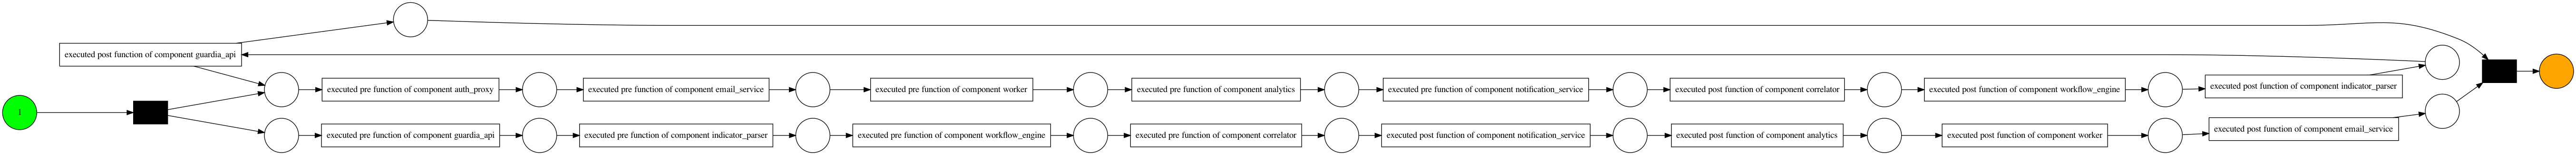

In [237]:
# Discovers a Petri net using the Alpha+ algorithm
mine2.generate_petri_net_alpha_plus()

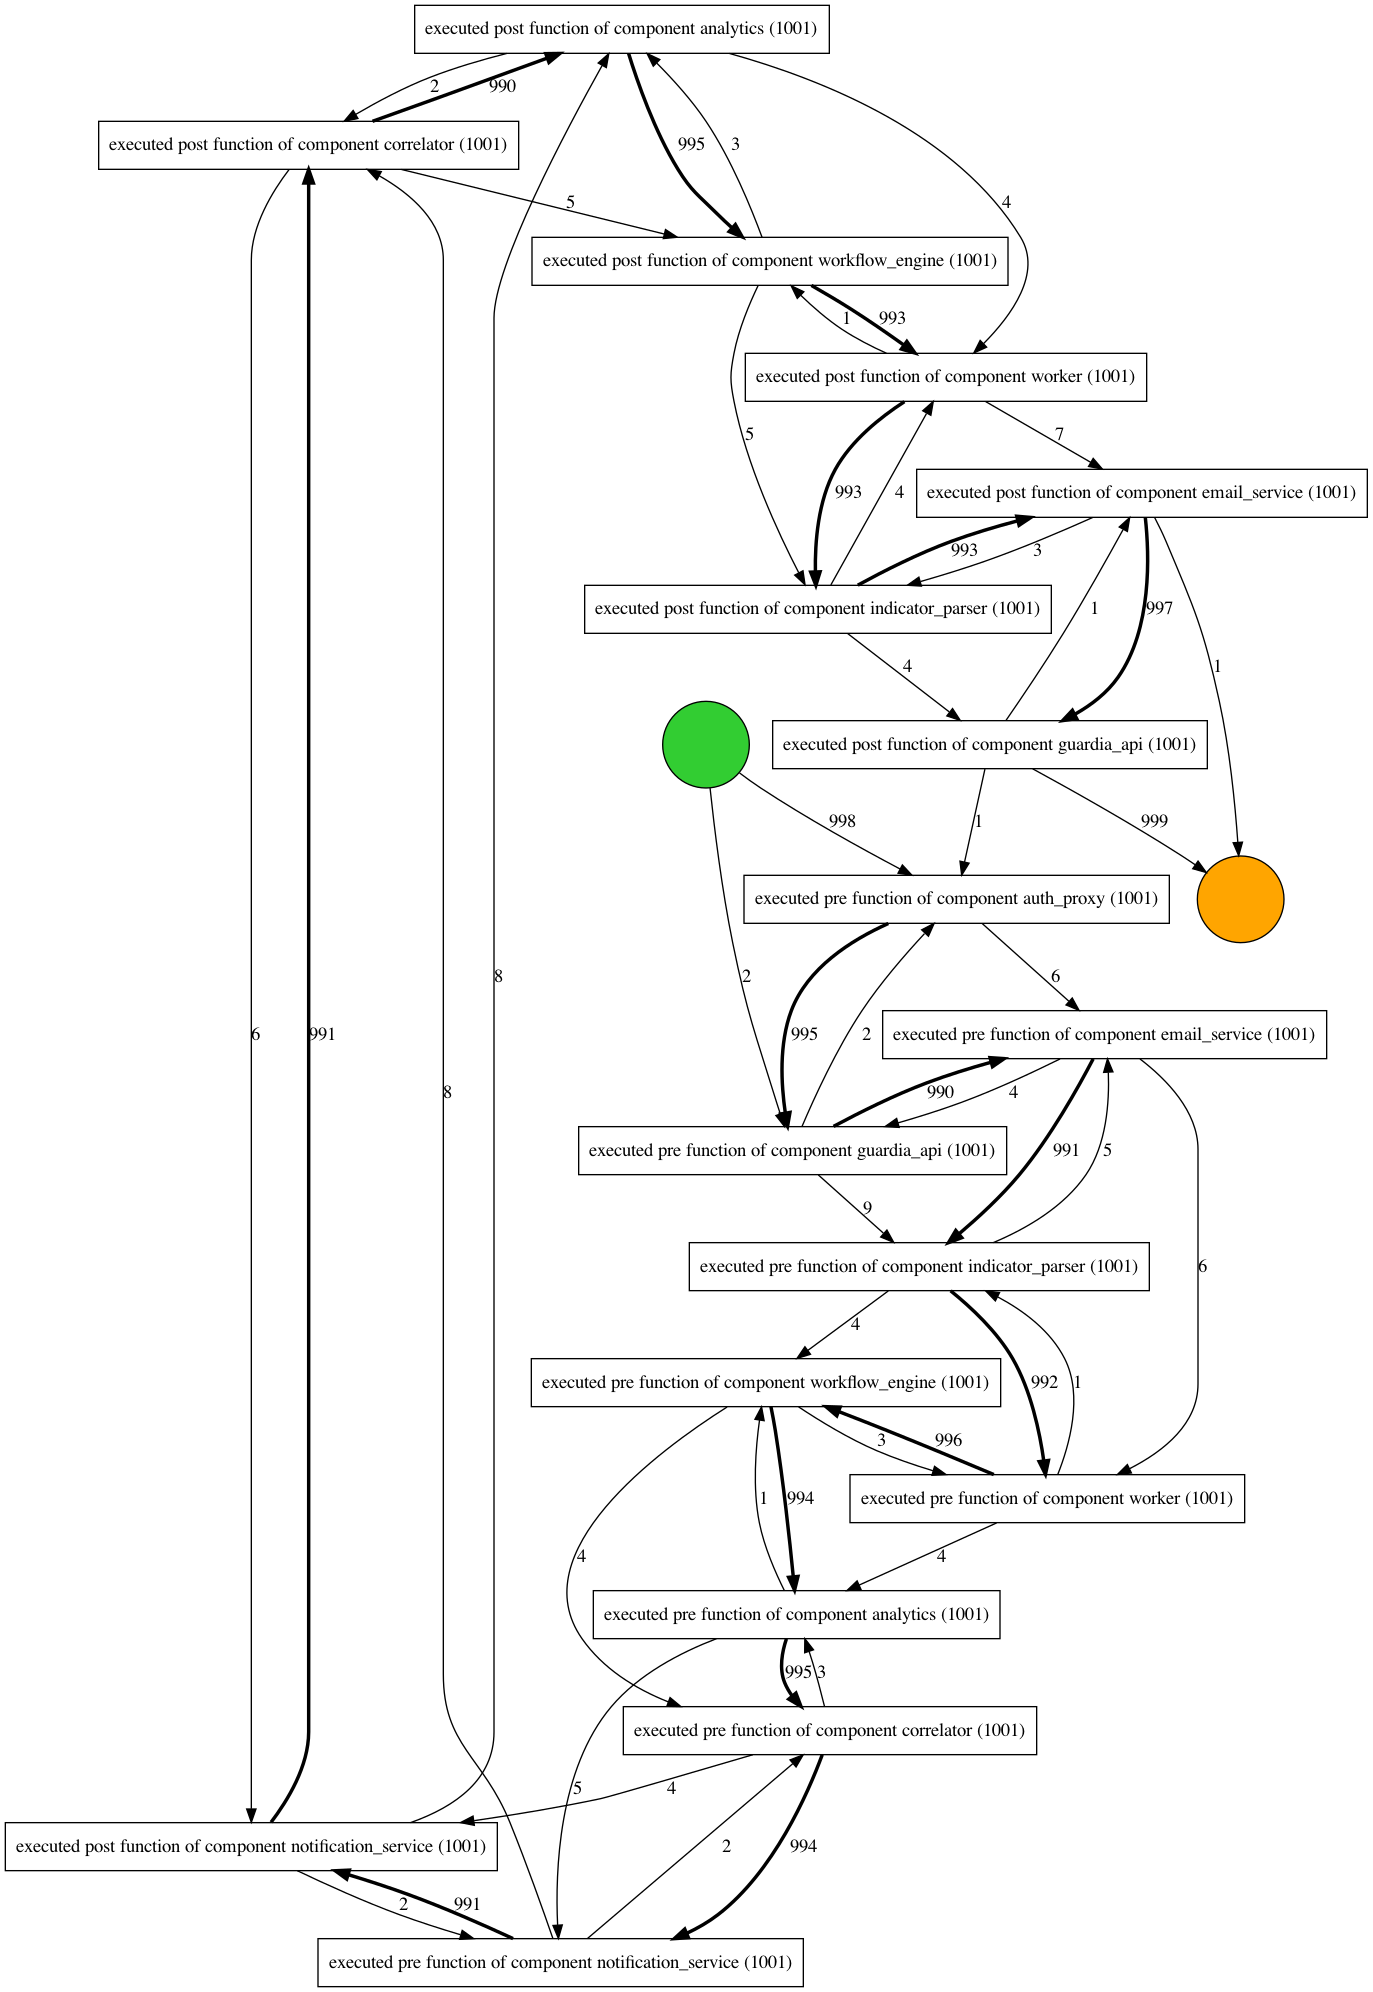

In [238]:
# Discovers a DFG from a log
mine2.directly_follows_graph()

Frequency: 


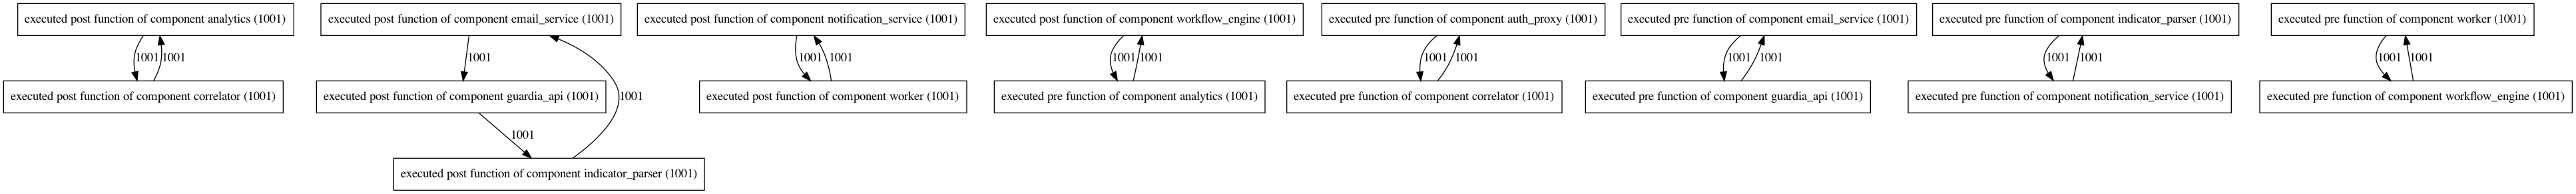

Performance: 


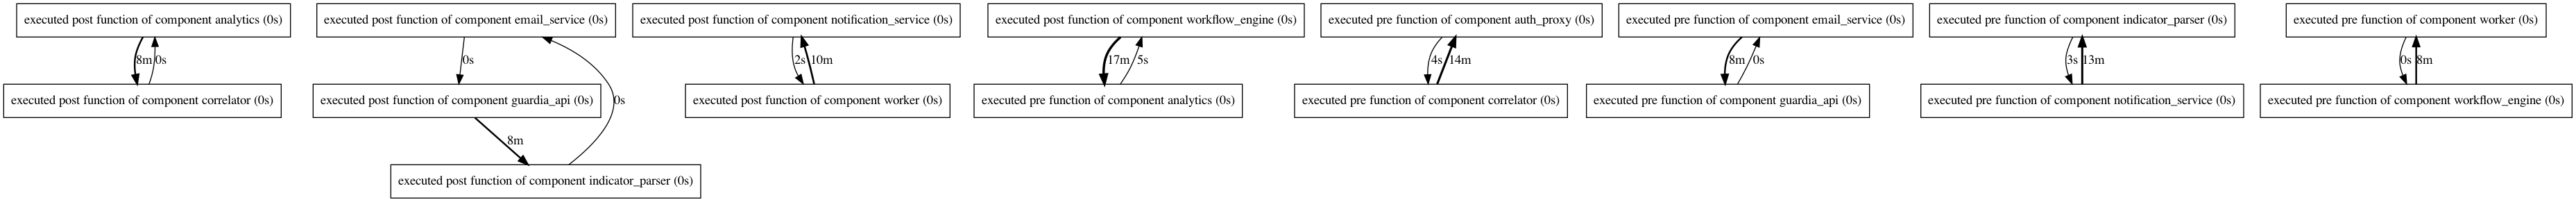

In [239]:
# Performance Graph
mine2.frequency_performance_graph()

In [240]:
# Process Replay
mine2.process_replay()

{({'executed post function of component indicator_parser'}, {'executed post function of component guardia_api'}): {'underfed_traces': set(), 'overfed_traces': set(), 'm': 0, 'r': 0, 'c': 1001, 'p': 1001}, ({'executed pre function of component workflow_engine'}, {'executed pre function of component correlator'}): {'underfed_traces': set(), 'overfed_traces': set(), 'm': 0, 'r': 0, 'c': 1001, 'p': 1001}, ({'executed pre function of component correlator'}, {'executed post function of component notification_service'}): {'underfed_traces': set(), 'overfed_traces': set(), 'm': 0, 'r': 0, 'c': 1001, 'p': 1001}, ({'executed post function of component correlator'}, {'executed post function of component workflow_engine'}): {'underfed_traces': set(), 'overfed_traces': set(), 'm': 0, 'r': 0, 'c': 1001, 'p': 1001}, start: {'underfed_traces': {{'attributes': {'concept:name': 104}, 'events': [{'time:timestamp': Timestamp('2021-01-12 17:18:06.525546+0000', tz='UTC'), 'concept:name': 'executed pre funct

In [241]:
# Diagnostics
mine2.print_diagnostics()

 Throughput Analysis: 
executed pre function of component guardia_api {'n_fit': 2, 'n_underfed': 998, 'fit_median_time': 4.85, 'underfed_median_time': 6.8, 'relative_throughput': 1.4020618556701032}


In [242]:
# Root Cause Analysis
# mine.root_cause_analysis()